## Martin Dionne

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.optimize as opt
from sklearn.preprocessing import MultiLabelBinarizer

# 1. Bisection


One of the most common algorithms for numerical root-finding is *bisection*.

To understand the idea, recall the well-known game where:

- Player A thinks of a secret number between 1 and 100  
- Player B asks if it’s less than 50  
  
  - If yes, B asks if it’s less than 25  
  - If no, B asks if it’s less than 75  
  

And so on.

This is bisection, a relative of [binary search](https://en.wikipedia.org/wiki/Binary_search_algorithm). It works for all sufficiently well behaved increasing continuous functions with $ f(a) < 0 < f(b) $. 

Write an implementation of the bisection algorith, `bisect(f, lower, upper, tol)` which, given a function `f`, a lower bound `lower` and an upper bound `upper` finds the point `x` where `f(x) = 0`. The parameter `tol` is a numerical tolerance, you should stop once your step size is smaller than `tol`.


Use it to minimize the function:

$$
f(x) = \sin(4 (x - 1/4)) + x + x^{20} - 1 \tag{2}
$$

in python: `lambda x: np.sin(4 * (x - 1/4)) + x + x**20 - 1`

The value where f(x) = 0 should be around `0.408`

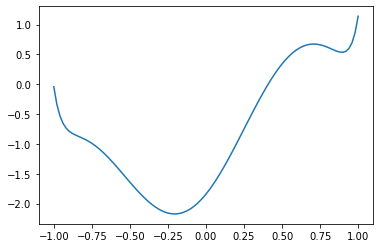

In [2]:
x = np.linspace(-1,1,100)
f = lambda x: np.sin(4 * (x - 1/4)) + x + x**20 - 1
plt.plot(x, f(x))

In [3]:
def bisect(f, lower, upper, tol):
    x = (upper + lower) / 2
    if np.abs(f(x)) > tol:
        if f(x) > 0 : 
            upper = x 
        else: 
            lower = x
        return bisect(f, lower, upper, tol)
    return x

In [4]:
bisect(f, -1, 1, 0.001) # 0.408

0.408203125

In [5]:
# verification
opt.bisect(f, -1, 1)

0.4082935042806639

# 1.2 (stretch) Recursive Bisect

Write a recursive version of the bisection algorithm

In [6]:
bisect(f, -1, 1, 0.001) # 0.408

0.408203125

# 2.1 Movies Regression

Write the best linear regression model you can on the [Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset?select=ratings.csv) to predict the profitability of a movie (revenue - budget). Maintain the interpretability of the model.

Few notes:

1. Clean your data! Movies where the budget or revenue are invalid should be thrown out

2. Be creative with feature engineering. You can include processing to one-hot encode the type of movie, etc.

3. The model should be useful for someone **who is thinking about making a movie**. So features like the popularity can't be used. You could, however, use the ratings to figure out if making "good" or "oscar bait" movies is a profitable strategy.

In [7]:
df = pd.read_csv('data/movies_metadata.csv')

# drop rows of Unreleased movies
df = df[df.status == 'Released']

# drop columns unique to the row
df = df.drop(columns=['id', 'imdb_id', 'original_title', 'overview', 'poster_path', 'tagline', 'title', 'status'])

# covert to boolean
df['adult'] = df['adult'].replace(('False', 'True'), (0,1))
df['belongs_to_collection'] = df['belongs_to_collection'].notna().replace((False, True), (0,1))
df['homepage'] = df['homepage'].notna().replace((False, True), (0,1))
df['video'] = df['video'].replace((False, True), (0,1))

# covert to date
df['release_date'] = pd.to_datetime(df['release_date'], format = '%Y-%m-%d', errors='coerce')
df['day'] = df['release_date'].dt.day
df['month'] = df['release_date'].dt.month
df['year'] = df['release_date'].dt.year

# drop features correlated to the popularity (after the fact)
df = df.drop(columns=['popularity', 'vote_average', 'vote_count', 'release_date', 'day'])

# fix revenue = 0, NaN budget = 0
df['budget'] = df['budget'].astype('int')
df.loc[df['budget'] == 0, 'budget'] = np.nan
df.loc[df['revenue'] == 0, 'revenue'] = np.nan

na = df.isnull().sum().to_frame(name = 'na')
na = na.loc[na.na != 0]
na

df = df.dropna()
df.head()

,adult,belongs_to_collection,budget,genres,homepage,original_language,production_companies,production_countries,revenue,runtime,spoken_languages,video,month,year
0,0,1,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1,en,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",0,10.0,1995.0
1,0,0,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",0,en,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",0,12.0,1995.0
3,0,0,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",0,en,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",0,12.0,1995.0
5,0,0,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",0,en,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",0,12.0,1995.0
8,0,0,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",0,en,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",0,12.0,1995.0


In [8]:
# drop columns non numerical columns (for now)
df = df.drop(columns=['genres', 'production_companies', 'production_countries', 'spoken_languages'])
df = df.drop(columns=['original_language'])

#json_features = ['genres', 'production_companies', 'production_countries', 'spoken_languages']
if 'json_featuresif' in locals():
    for f in json_features:
        df[f] = (df[f]
            .apply(eval)
            .apply(lambda row : [d['name'] for d in row])
            .astype(str)
            .apply(eval)
            )

    for f in json_features:
        df = df.join(pd.get_dummies(df[f].apply(pd.Series), prefix=f, prefix_sep="_", drop_first=True)).drop(columns=[f])

In [9]:
# drop column containing only zeros
df = df.drop(columns=['adult', 'video'])
df.sum()

belongs_to_collection    1.223000e+03
budget                   1.673032e+11
homepage                 1.913000e+03
revenue                  4.859818e+11
runtime                  5.904820e+05
month                    3.732100e+04
year                     1.075066e+07
dtype: float64

In [10]:
y = df['revenue']
X = df.drop(columns='revenue')

est = sm.OLS(y, sm.add_constant(X)).fit(cov_type='HC2')
est.summary()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 5
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     78.43
Date:                Fri, 29 Jan 2021   Prob (F-statistic):           1.21e-79
Time:                        19:04:47   Log-Likelihood:            -1.0702e+05
No. Observations:                5376   AIC:                         2.141e+05
Df Residuals:                    5369   BIC:                         2.141e+05
Df Model:                           6                                         
Covariance Type:                  HC2                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  9.104e+08   1.49e+08      6.129      0.000    6.19e+08     1.2e+09
belongs_to_collection   8.03e+07   4.48e+06     17.927      0.000    7.15e+07    8.91e+07
budget                    2.7290      0.097     28.163      0.000       2.539       2.919
homepage                 3.6e+07   3.19e+06     11.274      0.000    2.97e+07    4.23e+07
runtime                5.453e+05   8.34e+04      6.541      0.000    3.82e+05    7.09e+05
month                  4.577e+05   4.14e+05      1.106      0.269   -3.53e+05    1.27e+06
year                  -4.996e+05   7.53e+04     -6.635      0.000   -6.47e+05   -3.52e+05
==============================================================================
Omnibus:                     4717.134   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           420590.933
Skew:                           3.766   Prob(JB):                         0.00
Kurtosis:                      45.672   Cond. No.                     7.09e+09
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 7.09e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
#dropcol = (est.pvalues >= 0.05)
#dropcol = dropcol[dropcol==True].index
#X2 = X.drop(columns=dropcol)
#est2 = sm.OLS(y,sm.add_constant(X2)).fit(cov_type='HC2')
#est2.summary()

# 2.2 Movies Manual Regression

Use your `X` and `y` matrix from 2.1 to calculate the linear regression yourself using the normal equation $(X^T X)^{-1}X^Ty$.

Verify that the coefficients are the same.

In [12]:
# Returns array with [intercept, slope]
Xc = sm.add_constant(X.copy())

beta = np.linalg.inv(Xc.T @ Xc) @ Xc.T @ y
beta

0    9.104082e+08
1    8.029535e+07
2    2.729012e+00
3    3.600434e+07
4    5.453352e+05
5    4.577108e+05
6   -4.996080e+05
dtype: float64

In [13]:
est.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,9.104e+08,1.49e+08,6.129,0.000,6.19e+08,1.2e+09
belongs_to_collection,8.03e+07,4.48e+06,17.927,0.000,7.15e+07,8.91e+07
budget,2.7290,0.097,28.163,0.000,2.539,2.919
homepage,3.6e+07,3.19e+06,11.274,0.000,2.97e+07,4.23e+07
runtime,5.453e+05,8.34e+04,6.541,0.000,3.82e+05,7.09e+05
month,4.577e+05,4.14e+05,1.106,0.269,-3.53e+05,1.27e+06
year,-4.996e+05,7.53e+04,-6.635,0.000,-6.47e+05,-3.52e+05


# 2.3 Movies gradient descent regression

Use your `X` and `y` matrix from 2.1 to calculate the linear regression yourself using **gradient descent**. 

Hint: use `scipy.optimize` and remember we're finding the $\beta$ that minimizes the squared loss function of linear regression: $f(\beta) = (\beta X - y)^2$. This will look like part 3 of this lecture.

Verify your coefficients are similar to the ones in 2.1 and 2.2. They won't necessarily be exactly the same, but should be roughly similar.

In [14]:
def GradientDescent(betas, y, x):
    sq_loss = np.sum( (np.dot(x, betas) - y) ** 2 )
    return sq_loss

In [15]:
from scipy.optimize import minimize

# get x values with constant
y = df['revenue']
x = sm.add_constant(df.drop(columns='revenue'))

#create beta hat vector to maximize on (initiatlized with zeros)
betas = np.zeros(np.shape(x)[1])

#unvectorized MLE estimation
#dg_est = minimize(GradientDescent, betas, args=(y,x), method='bfgs')
dg_est = minimize(GradientDescent, betas, args=(y,x), method='Powell')

#print vector of maximized betahats
dg_est['x']

array([-9.03292366e+07,  8.20200999e+07,  2.68498327e+00,  3.07130391e+07,
        5.79176139e+05,  6.04544390e+05, -1.39448525e+02])

In [16]:
beta

0    9.104082e+08
1    8.029535e+07
2    2.729012e+00
3    3.600434e+07
4    5.453352e+05
5    4.577108e+05
6   -4.996080e+05
dtype: float64